In [60]:
# This script is used to generate and visualize masks for a given image
# input: image path, class names, threshold, text_prompt, text_template, timesteps
# output: source img, loss, cross att, heatmap, mask

## Initialization

In [61]:
# set gpu device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [62]:
# package and helper functions
import random
import warnings
from math import sqrt
from typing import List, Optional, Dict

from dataclasses import dataclass
import numpy as np
import torch
import torch.nn.functional as F
from diffusers import AutoPipelineForText2Image
from diffusers.models.attention_processor import Attention
from PIL import Image
import matplotlib.pyplot as plt

from utils.attention_control import (
    AttentionStoreHook,
    AttnProcessor,
    aggregate_cross_att,
    aggregate_self_att,
)
from utils.diffusion import Diffusion
from utils.img2text import Img2Text
from utils.parse_args import parse_args

T = torch.Tensor
TL = List[T]
TN = Optional[T]


class AvgAttentionStoreHook(AttentionStoreHook):
    @torch.inference_mode
    def forward(self, attn: Attention, q: T, k: T, v: T, sim: T, out: T) -> T:
        """
        q: (b, h, i, d)
        k, v: (b, h, j, d)
        sim: (b, h, i, j)
        out: (b, i, n)
        """
        key = "cross_att" if attn.is_cross_attention else "self_att"
        self.step_store[key].append(sim.mean(dim=1))
        return out


@dataclass
class ClassData:
    loss_img: Optional[np.ndarray] = None
    cross_att_img: Optional[np.ndarray] = None
    heatmap: Optional[np.ndarray] = None
    mask: Optional[np.ndarray] = None
    text: str = ""
    loss: TN = None
    cross_att: TN = None
    self_att: TN = None

    def __getitem__(self, key):
        return getattr(self, key)

    def __setitem__(self, key, value):
        setattr(self, key, value)


def parse_timesteps(timesteps: List[List]) -> List:
    parsed_timesteps = []
    for t in timesteps:
        if len(t) == 3:
            parsed_timesteps.extend(range(t[0], t[1], t[2]))
        else:  # len(t) == 4, random sample
            parsed_timesteps.extend([random.randint(t[1], t[2]) for _ in range(t[3])])
    return parsed_timesteps


def show_data(img: Image, cls_to_data: Dict[str, ClassData]):
    for cls in cls_to_data:
        print(
            f"class: {cls} --- loss: {cls_to_data[cls].loss} --- text: {cls_to_data[cls].text}"
        )

    row_cnt = len(cls_to_data)
    col_cnt = 5
    fig, axs = plt.subplots(row_cnt, col_cnt, figsize=(col_cnt * 3, row_cnt * 3))
    placeholder = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
    placeholder_title = "No Image Available"

    if row_cnt == 1:
        axs = [axs]

    for i, (cls, data) in enumerate(cls_to_data.items()):
        axs[i][0].set_ylabel(cls)
        axs[i][0].imshow(img)
        images = [data.loss_img, data.cross_att_img, data.heatmap, data.mask]
        for j, image in enumerate(images):
            if image is not None:
                axs[i][j + 1].imshow(image)
            else:
                axs[i][j + 1].imshow(placeholder)
                axs[i][j + 1].set_title(placeholder_title)

    for i in range(row_cnt):
        for j in range(col_cnt):
            axs[i][j].tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
                bottom=False,
            )

    for j, title in enumerate(
        ["source img", "loss img", "cross att img", "heatmap", "mask"]
    ):
        axs[0][j].set_title(title)

    plt.tight_layout()
    plt.show()

In [63]:
# load config and model
warnings.filterwarnings("ignore")
config = parse_args("segmentation", False, [])
img2text = Img2Text(config)
diffusion_dtype = torch.float16 if config.diffusion.dtype == "fp16" else torch.float32
pipe = AutoPipelineForText2Image.from_pretrained(
    config.diffusion.variant,
    torch_dtype=diffusion_dtype,
    use_safetensors=True,
    cache_dir=config.model_dir,
    device_map=config.diffusion.device_map,
)
# register attention processor for attention hooks
pipe.unet.set_attn_processor(AttnProcessor())
store_hook = AvgAttentionStoreHook(pipe)
diffusion = Diffusion(pipe)
text_emb_null = diffusion.encode_prompt("")

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


## Input

In [69]:
# input
# voc_10_car img: 0
# img_path = "./datasets/VOCdevkit/VOC2012/JPEGImages/2009_003722.jpg"
# cls_names = ["car", "chair", "motorbike", "people"]
# voc_10_car img: 2
img_path = "./datasets/VOCdevkit/VOC2012/JPEGImages/2011_001949.jpg"
cls_names = ["bicycle", "buses", "car", "people"]
# voc_10_car img: 3
# img_path = "./datasets/VOCdevkit/VOC2012/JPEGImages/2010_001246.jpg"
# cls_names = ["bicycle", "car", "people", "plant"]
# voc_10_car img: 4
# img_path = "./datasets/VOCdevkit/VOC2012/JPEGImages/2008_005139.jpg"
# cls_names = ["buses", "car", "motorbike", "plant"]
# voc_10_car img: 6
# img_path = "./datasets/VOCdevkit/VOC2012/JPEGImages/2008_003978.jpg"
# cls_names = ["car", "dog", "people", "plant"]
# voc_10_car img: 7
# img_path = "./datasets/VOCdevkit/VOC2012/JPEGImages/2009_001997.jpg"
# cls_names = ["bicycle", "buses", "car", "people"]
threshold = 0.6
text_prompt = "a photograph of {source_cls}"  # text prompt to generate source_gen
text_template = (
    "{source_cls}"  # text template to generate mask
)
collect_timesteps = [["random", 1, 200, 100]]

# post process input
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

collect_timesteps = parse_timesteps(collect_timesteps)
img = Image.open(img_path).convert("RGB")
w, h = img.size
z_source = diffusion.encode_vae_image(img)
# use same noise for all classes at the same timestep
collect_noise = torch.randn(
    len(collect_timesteps), *z_source.shape[1:], device=z_source.device
)

## Generate Mask Per Class Using Multiple Sentences

class: bicycle --- loss: 44.671451568603516 --- text: bicycle
class: buses --- loss: 44.585426330566406 --- text: buses
class: car --- loss: 44.67687225341797 --- text: car
class: people --- loss: 44.67654800415039 --- text: people


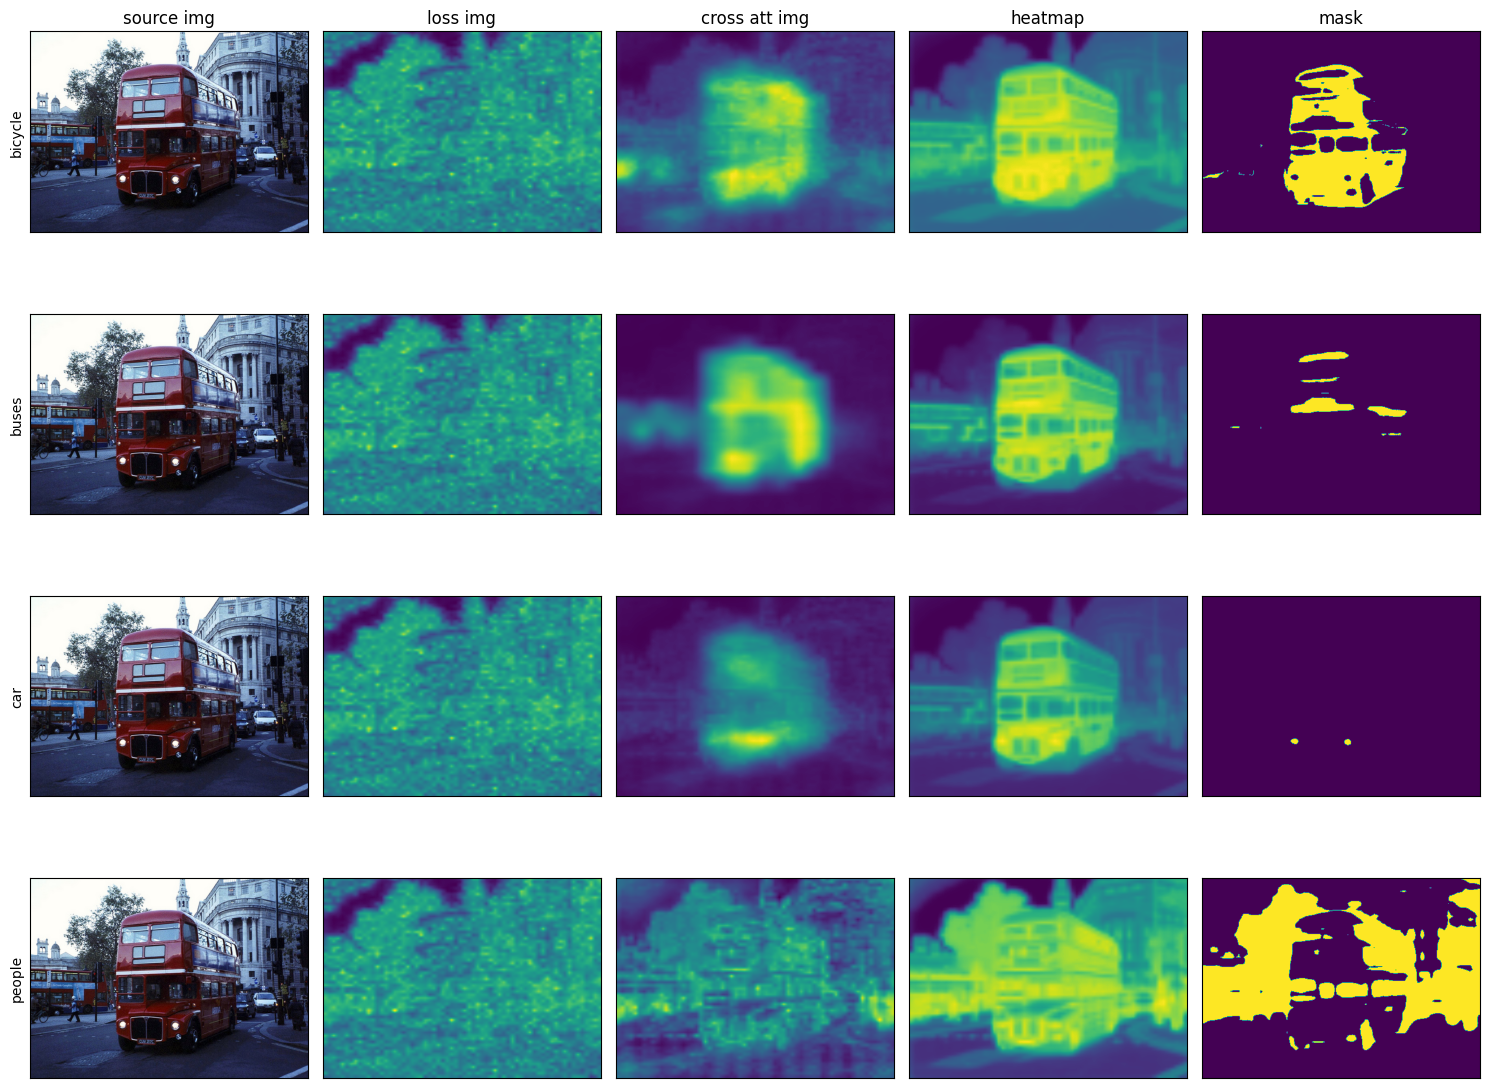

In [70]:
with torch.inference_mode():
    cls_to_data1: Dict[str, ClassData] = {}
    heatmaps = []
    for cls_name in cls_names:
        loss, loss_img = 0, 0
        cls_to_data1[cls_name] = ClassData()
        # text input
        source_cls = cls_name
        source_gen = img2text(img, img_path, text_prompt.format(source_cls=source_cls))
        source_text = text_template.format(source_cls=source_cls, source_gen=source_gen)
        cls_to_data1[cls_name].text = source_text
        text_emb_source = diffusion.encode_prompt(source_text)
        # pos of source_cls in source_text
        source_text_id = pipe.tokenizer.encode(source_text)
        source_cls_id = pipe.tokenizer.encode(source_cls)[1:-1]
        for start in range(len(source_text_id) - len(source_cls_id) + 1):
            if source_text_id[start : start + len(source_cls_id)] == source_cls_id:
                pos = [start + i for i in range(len(source_cls_id))]
                break
        if pos[-1] + 1 < len(source_text_id) and pipe.tokenizer.decode(
            source_text_id[pos[-1] + 1]
        ).endswith("ing"):
            pos.append(pos[-1] + 1)
        # collect attention maps
        store_hook.reset()
        for idx, timestep in enumerate(collect_timesteps):
            z_t_source, eps = diffusion.noise_input(
                z_source, timestep, collect_noise[idx]
            )
            eps_pred = diffusion.get_eps_prediction(
                [z_t_source],
                [timestep],
                [text_emb_source],
                {"attention_hooks": [store_hook]},
            )
            loss += F.mse_loss(eps_pred, eps, reduction="mean")
            loss_img += torch.abs(eps_pred - eps).to(torch.float32)
        # loss = sigma(mse(eps_pred,eps))
        # loss_img = sigma(abs(eps_pred-eps))
        cls_to_data1[cls_name].loss = loss
        loss_img = loss_img.sum(dim=1).squeeze()
        loss_img = loss_img.view(1, 1, loss_img.shape[0], loss_img.shape[1])
        loss_img: T = F.interpolate(loss_img, size=(h, w), mode="bilinear")
        loss_img = (loss_img - loss_img.min()) / (loss_img.max() - loss_img.min()) * 255
        cls_to_data1[cls_name].loss_img = (
            loss_img.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
        # cross attention
        mask = aggregate_cross_att(store_hook, 0, pos, config)
        cls_to_data1[cls_name].cross_att = mask.clone()
        max_res = round(sqrt(mask.shape[0]))
        cross_att = mask.view(1, 1, max_res, max_res)
        cross_att: T = F.interpolate(cross_att, size=(h, w), mode="bilinear")
        cross_att = (
            (cross_att - cross_att.min()) / (cross_att.max() - cross_att.min()) * 255
        )
        cls_to_data1[cls_name].cross_att_img = (
            cross_att.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
        # heatmap
        self_att = aggregate_self_att(store_hook, 0, config)
        cls_to_data1[cls_name].self_att = self_att.clone()
        mask = torch.matmul(self_att, mask)
        mask = mask.view(1, 1, max_res, max_res)
        mask: T = F.interpolate(mask, size=(h, w), mode="bilinear")
        mask = (mask - mask.min()) / (mask.max() - mask.min()) * 255
        heatmaps.append(mask.squeeze())
        cls_to_data1[cls_name].heatmap = (
            mask.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
    # mask
    heatmaps = torch.stack(heatmaps, dim=0)
    heatmaps_idx = heatmaps.argmax(dim=0)
    heatmaps_val = heatmaps.max(dim=0).values
    heatmaps_idx[heatmaps_val < threshold * 255] = 255  # background
    for idx, cls_name in enumerate(cls_to_data1):
        mask = (heatmaps_idx == idx).float() * 255
        cls_to_data1[cls_name].mask = mask.cpu().detach().numpy().astype(np.uint8)
    # show data
    show_data(img, cls_to_data1)

## Generate Mask For All Classes In One Sentence

class: bicycle --- loss: 44.58944320678711 --- text: bicycle,buses,car,people
class: buses --- loss: 44.58944320678711 --- text: bicycle,buses,car,people
class: car --- loss: 44.58944320678711 --- text: bicycle,buses,car,people
class: people --- loss: 44.58944320678711 --- text: bicycle,buses,car,people


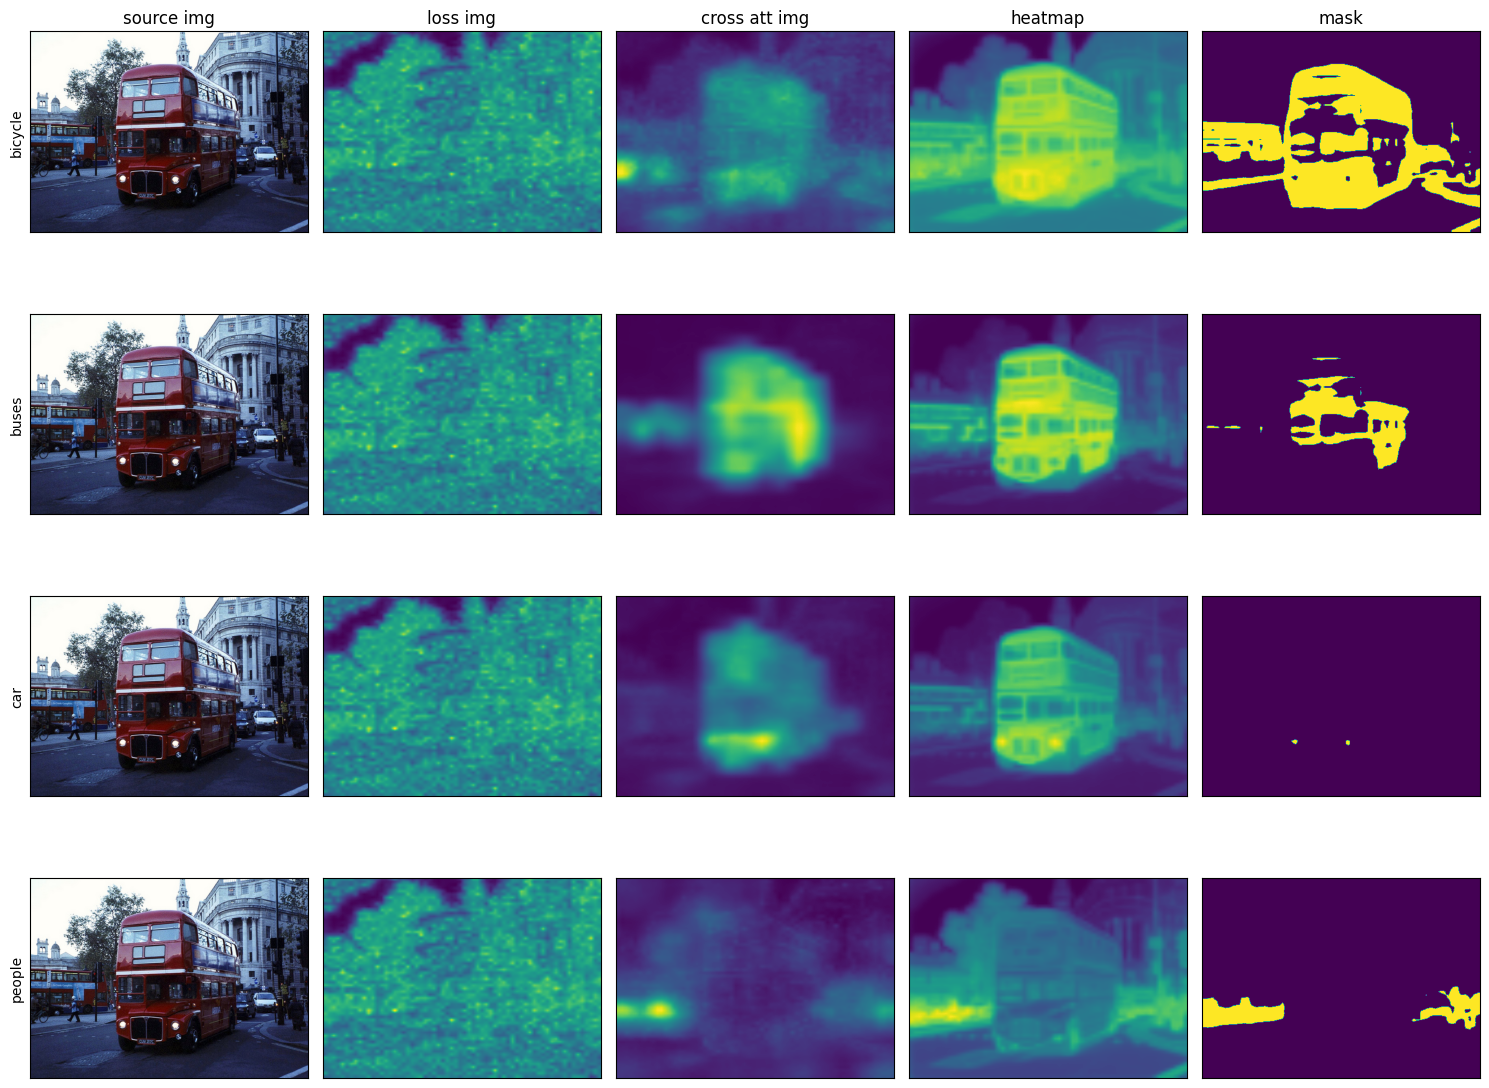

In [71]:
with torch.inference_mode():
    cls_to_data2: Dict[str, ClassData] = {}
    heatmaps = []
    source_text = ",".join(cls_names)
    text_emb_source = diffusion.encode_prompt(source_text)
    loss, loss_img = 0, 0
    # collect attention maps
    store_hook.reset()
    for idx, timestep in enumerate(collect_timesteps):
        z_t_source, eps = diffusion.noise_input(z_source, timestep, collect_noise[idx])
        eps_pred = diffusion.get_eps_prediction(
            [z_t_source],
            [timestep],
            [text_emb_source],
            {"attention_hooks": [store_hook]},
        )
        loss += F.mse_loss(eps_pred, eps, reduction="mean")
        loss_img += torch.abs(eps_pred - eps).to(torch.float32)
    # loss = sigma(mse(eps_pred,eps))
    # loss_img = sigma(abs(eps_pred-eps))
    loss_img = loss_img.sum(dim=1).squeeze()
    loss_img = loss_img.view(1, 1, loss_img.shape[0], loss_img.shape[1])
    loss_img: T = F.interpolate(loss_img, size=(h, w), mode="bilinear")
    loss_img = (loss_img - loss_img.min()) / (loss_img.max() - loss_img.min()) * 255
    loss_img = loss_img.squeeze().cpu().detach().numpy().astype(np.uint8)

    for cls_name in cls_names:
        cls_to_data2[cls_name] = ClassData()
        cls_to_data2[cls_name].text = source_text
        # pos of cls_name in source_text
        source_text_id = pipe.tokenizer.encode(source_text)
        source_cls_id = pipe.tokenizer.encode(cls_name)[1:-1]
        for start in range(len(source_text_id) - len(source_cls_id) + 1):
            if source_text_id[start : start + len(source_cls_id)] == source_cls_id:
                pos = [start + i for i in range(len(source_cls_id))]
                break
        # loss data
        cls_to_data2[cls_name].loss = loss
        cls_to_data2[cls_name].loss_img = loss_img
        # cross attention
        mask = aggregate_cross_att(store_hook, 0, pos, config)
        cls_to_data2[cls_name].cross_att = mask.clone()
        max_res = round(sqrt(mask.shape[0]))
        cross_att = mask.view(1, 1, max_res, max_res)
        cross_att: T = F.interpolate(cross_att, size=(h, w), mode="bilinear")
        cross_att = (
            (cross_att - cross_att.min()) / (cross_att.max() - cross_att.min()) * 255
        )
        cls_to_data2[cls_name].cross_att_img = (
            cross_att.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
        # heatmap
        self_att = aggregate_self_att(store_hook, 0, config)
        cls_to_data2[cls_name].self_att = self_att.clone()
        mask = torch.matmul(self_att, mask)
        mask = mask.view(1, 1, max_res, max_res)
        mask: T = F.interpolate(mask, size=(h, w), mode="bilinear")
        mask = (mask - mask.min()) / (mask.max() - mask.min()) * 255
        heatmaps.append(mask.squeeze())
        cls_to_data2[cls_name].heatmap = (
            mask.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
    # mask
    heatmaps = torch.stack(heatmaps, dim=0)
    heatmaps_idx = heatmaps.argmax(dim=0)
    heatmaps_val = heatmaps.max(dim=0).values
    heatmaps_idx[heatmaps_val < threshold * 255] = 255  # background
    for idx, cls_name in enumerate(cls_to_data2):
        mask = (heatmaps_idx == idx).float() * 255
        cls_to_data2[cls_name].mask = mask.cpu().detach().numpy().astype(np.uint8)
    # show data
    show_data(img, cls_to_data2)

## Generate Mask For "Start", "Null Text" And "End" Token

class: start --- loss: 44.68207931518555 --- text: 
class: null --- loss: 44.68207931518555 --- text: 
class: end --- loss: 44.68207931518555 --- text: 


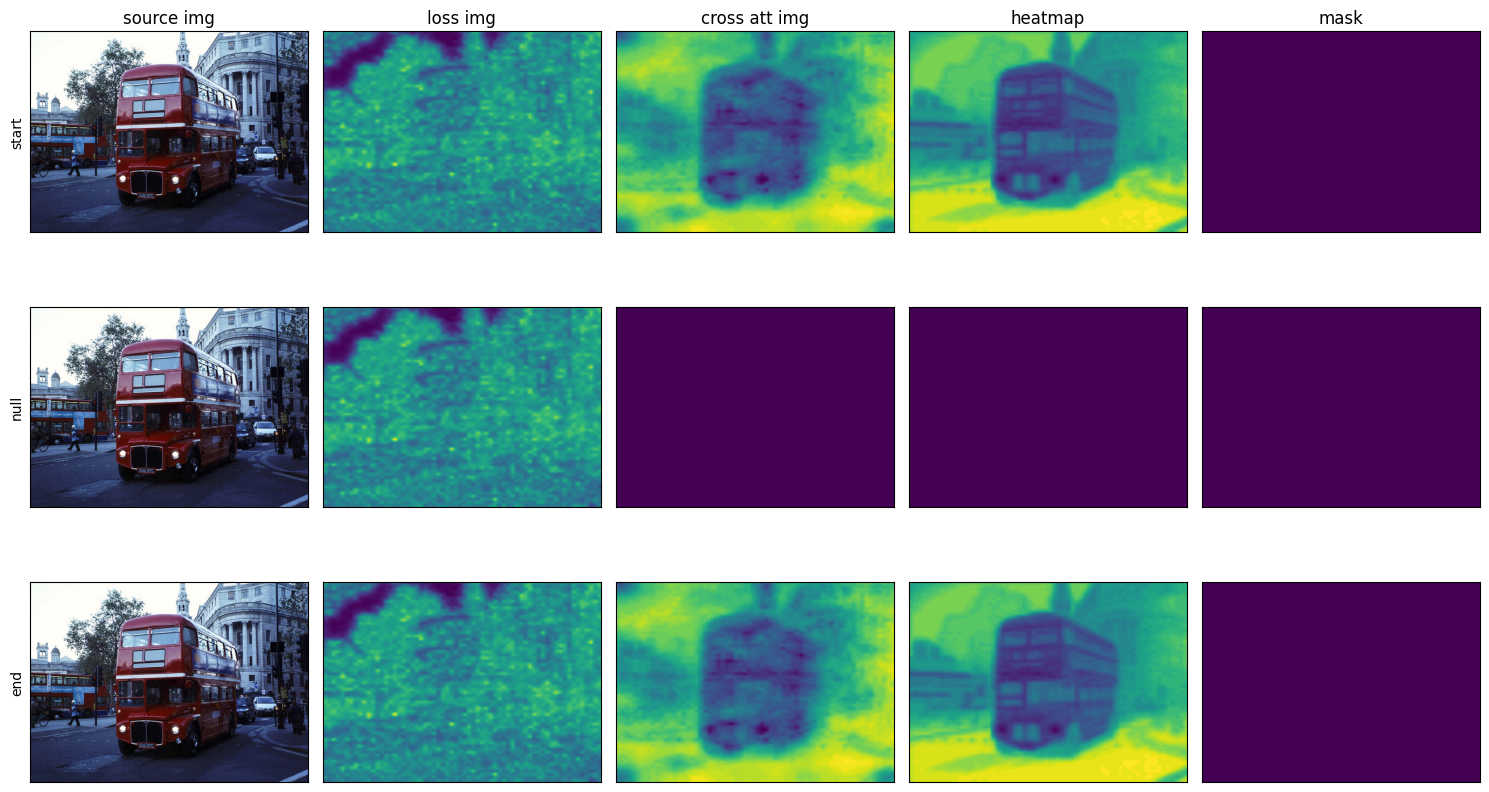

In [72]:
with torch.inference_mode():
    cls_to_data3: Dict[str, ClassData] = {}
    heatmaps = []
    source_text = ""
    special_cls_names = ["start", "null", "end"]
    text_emb_source = diffusion.encode_prompt(source_text)
    loss, loss_img = 0, 0
    # collect attention maps
    store_hook.reset()
    for idx, timestep in enumerate(collect_timesteps):
        z_t_source, eps = diffusion.noise_input(z_source, timestep, collect_noise[idx])
        eps_pred = diffusion.get_eps_prediction(
            [z_t_source],
            [timestep],
            [text_emb_source],
            {"attention_hooks": [store_hook]},
        )
        loss += F.mse_loss(eps_pred, eps, reduction="mean")
        loss_img += torch.abs(eps_pred - eps).to(torch.float32)
    # loss = sigma(mse(eps_pred,eps))
    # loss_img = sigma(abs(eps_pred-eps))
    loss_img = loss_img.sum(dim=1).squeeze()
    loss_img = loss_img.view(1, 1, loss_img.shape[0], loss_img.shape[1])
    loss_img: T = F.interpolate(loss_img, size=(h, w), mode="bilinear")
    loss_img = (loss_img - loss_img.min()) / (loss_img.max() - loss_img.min()) * 255
    loss_img = loss_img.squeeze().cpu().detach().numpy().astype(np.uint8)

    for cls_name in special_cls_names:
        cls_to_data3[cls_name] = ClassData()
        cls_to_data3[cls_name].text = source_text
        # pos of cls_name in source_text
        if cls_name == "start":
            pos = [0]
        elif cls_name == "null":
            pos = [i for i in range(1, text_emb_source.shape[0] - 1)]
        else:
            pos = [text_emb_source.shape[0] - 1]
        # loss data
        cls_to_data3[cls_name].loss = loss
        cls_to_data3[cls_name].loss_img = loss_img
        # cross attention
        mask = aggregate_cross_att(store_hook, 0, pos, config)
        cls_to_data3[cls_name].cross_att = mask.clone()
        max_res = round(sqrt(mask.shape[0]))
        cross_att = mask.view(1, 1, max_res, max_res)
        cross_att: T = F.interpolate(cross_att, size=(h, w), mode="bilinear")
        cross_att = (
            (cross_att - cross_att.min()) / (cross_att.max() - cross_att.min()) * 255
        )
        cls_to_data3[cls_name].cross_att_img = (
            cross_att.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
        # heatmap
        self_att = aggregate_self_att(store_hook, 0, config)
        cls_to_data3[cls_name].self_att = self_att.clone()
        mask = torch.matmul(self_att, mask)
        mask = mask.view(1, 1, max_res, max_res)
        mask: T = F.interpolate(mask, size=(h, w), mode="bilinear")
        mask = (mask - mask.min()) / (mask.max() - mask.min()) * 255
        heatmaps.append(mask.squeeze())
        cls_to_data3[cls_name].heatmap = (
            mask.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
    # mask
    heatmaps = torch.stack(heatmaps, dim=0)
    heatmaps_idx = heatmaps.argmax(dim=0)
    heatmaps_val = heatmaps.max(dim=0).values
    heatmaps_idx[heatmaps_val < threshold * 255] = 255  # background
    for idx, cls_name in enumerate(cls_to_data3):
        mask = (heatmaps_idx == idx).float() * 255
        cls_to_data3[cls_name].mask = mask.cpu().detach().numpy().astype(np.uint8)
    # show data
    show_data(img, cls_to_data3)

## Combine All Data And Generate The Final Mask

class: bicycle --- loss: 44.671451568603516 --- text: bicycle
class: buses --- loss: 44.585426330566406 --- text: buses
class: car --- loss: 44.67687225341797 --- text: car
class: people --- loss: 44.67654800415039 --- text: people


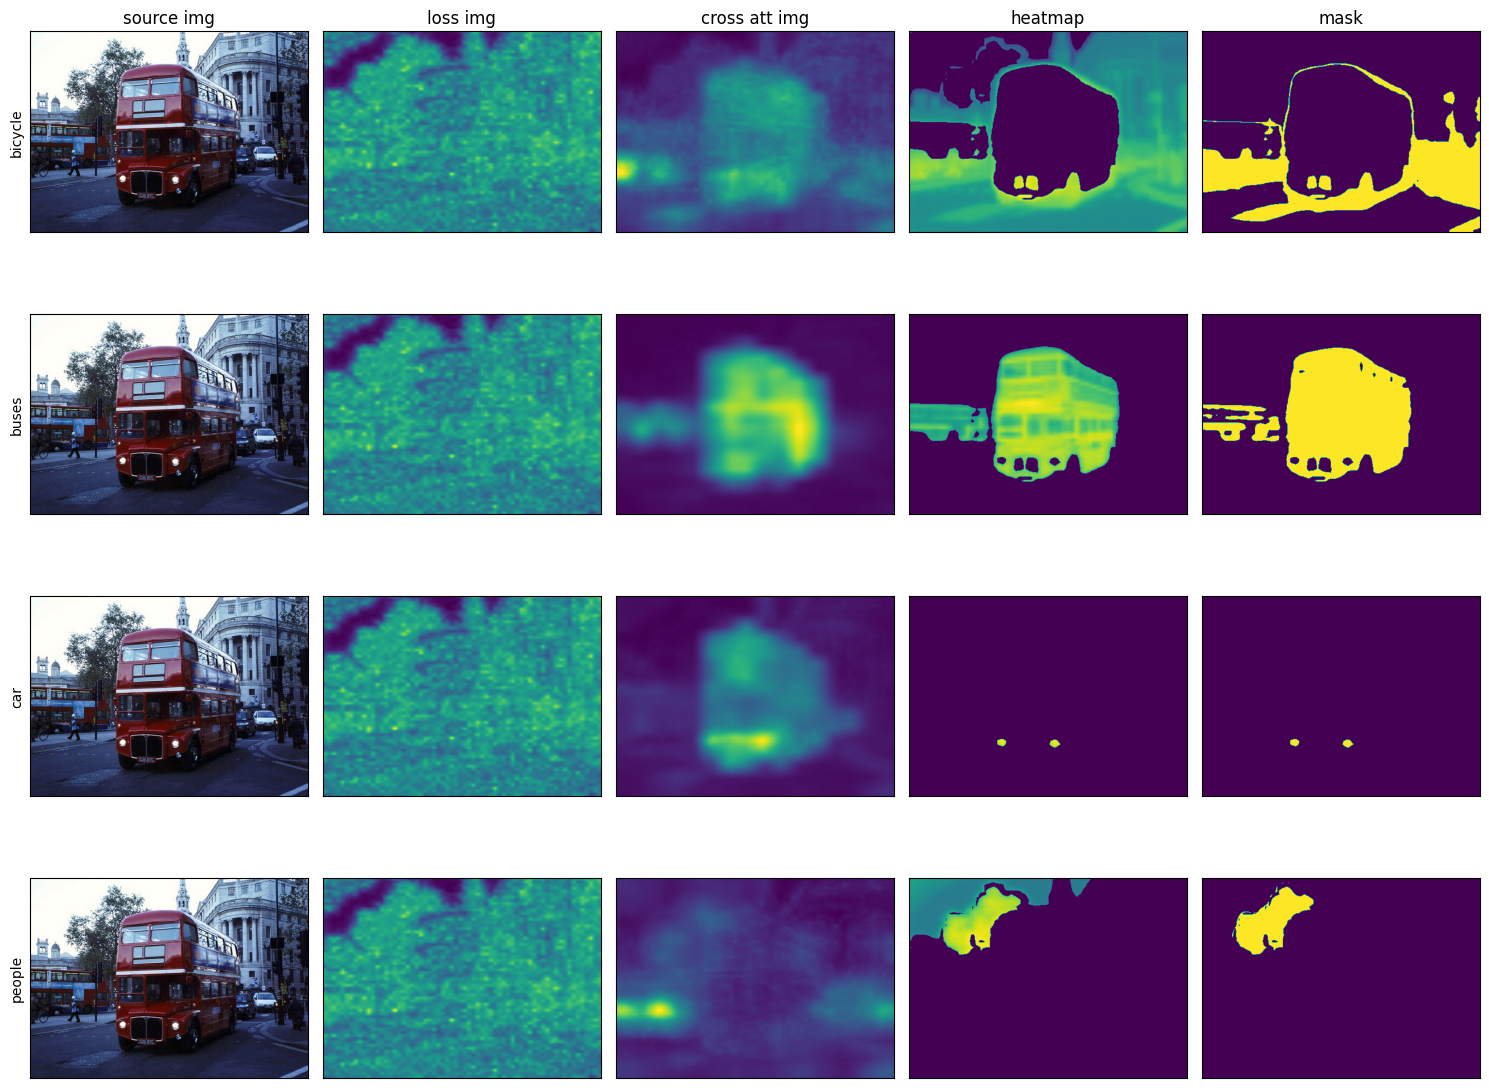

In [77]:
with torch.inference_mode():
    cls_to_data4: Dict[str, ClassData] = {}
    losses = []
    # collect cross attention and ELBO(losses)
    for cls_name in cls_names:
        cls_to_data4[cls_name] = ClassData()
        cls_to_data4[cls_name].cross_att = cls_to_data2[cls_name].cross_att.clone()
        cls_to_data4[cls_name].loss = cls_to_data1[cls_name].loss
        cls_to_data4[cls_name].loss_img = cls_to_data1[cls_name].loss_img
        cls_to_data4[cls_name].text = cls_to_data1[cls_name].text
        losses.append(cls_to_data1[cls_name].loss)
    losses = torch.stack(losses, dim=0).squeeze()
    # TODO: prepare normalization Temperature using ELBO
    temperature = torch.ones(losses.shape[0], device=losses.device)
    loss_mean = losses.mean()
    loss_std = losses.std()
    loss_minus_mean = losses - loss_mean
    
    # cross attention normalization with ELBO
    for idx, cls_name in enumerate(cls_names):
        cross_att = cls_to_data4[cls_name].cross_att
        cross_att = (
            (cross_att - cross_att.min()) / (cross_att.max() - cross_att.min())
        ) ** temperature[idx]
        cls_to_data4[cls_name].cross_att = cross_att
    # get cross attention image after normalization
    for cls_name in cls_names:
        max_res = round(sqrt(cls_to_data4[cls_name].cross_att.shape[0]))
        cross_att = cls_to_data4[cls_name].cross_att.view(1, 1, max_res, max_res)
        cross_att: T = F.interpolate(cross_att, size=(h, w), mode="bilinear")
        cross_att = cross_att.clamp(0, 1) * 255
        cls_to_data4[cls_name].cross_att_img = (
            cross_att.squeeze().cpu().detach().numpy().astype(np.uint8)
        )
    # using self attention to refine cross attention
    # OPTION: use null text or other tokens
    heatmaps = []
    for cls_name in cls_names:
        cls_to_data4[cls_name].self_att = cls_to_data2[cls_name].self_att.clone()
        heatmap = torch.matmul(
            cls_to_data4[cls_name].self_att, cls_to_data4[cls_name].cross_att
        )
        heatmap = heatmap.view(1, 1, max_res, max_res)
        heatmap: T = F.interpolate(heatmap, size=(h, w), mode="bilinear")
        heatmaps.append(heatmap.squeeze())
    # let heatmap of each class mutually exclusive
    heatmaps = torch.stack(heatmaps, dim=0)
    heatmaps_argmax = heatmaps.argmax(dim=0)
    for cls_idx in range(len(cls_names)):
        heatmaps[cls_idx][heatmaps_argmax != cls_idx] = 0
    # min-max normalization of heatmaps
    for cls_idx in range(len(cls_names)):
        heatmaps[cls_idx] = (heatmaps[cls_idx] - heatmaps[cls_idx].min()) / (
            heatmaps[cls_idx].max() - heatmaps[cls_idx].min()
        )
        cls_to_data4[cls_names[cls_idx]].heatmap = (
            (heatmaps[cls_idx] * 255).cpu().detach().numpy().astype(np.uint8)
        )
    # generate mask using heatmaps
    heatmaps_idx = heatmaps.argmax(dim=0)
    heatmaps_val = heatmaps.max(dim=0).values
    heatmaps_idx[heatmaps_val < threshold] = 255  # background
    for idx, cls_name in enumerate(cls_to_data4):
        mask = (heatmaps_idx == idx).float() * 255
        cls_to_data4[cls_name].mask = mask.cpu().detach().numpy().astype(np.uint8)
    # show data
    show_data(img, cls_to_data4)